*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<img style="padding: 10px; float:right;" alt="CC-BY-SA icon.svg in public domain" src="https://upload.wikimedia.org/wikipedia/commons/d/d0/CC-BY-SA_icon.svg" width="125">

<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/notebooks/module02_03_perceptron.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%autosave 0

Autosave disabled


# Linear models for classification: the perceptron


### Labeled data

Reminder:  A labeled dataset is a collection of feature vectors and their associated labels:

$$
\mathcal{D} = \{ \;(\mathbf{x}_i, y_i) \; \}_{i=1}^N
$$

where $\mathbf{x}_i \in \mathbb{R}^d$ and $y_i$ is the label associated with $\mathbf{x}_i$.
$\mathbb{R}^d$ is the set of all $d$-dimensional vectors with entries that are real numbers.

In this notebook we will focus on binary classification problems where  each example is classified into one of two classes.  Here we will use the labels $\{ -1, 1 \}$.

In [2]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, class_sep=0.6, random_state=1)
X.shape, y.shape

((100, 2), (100,))

This data is **linearly separable**:  there exists a hyperplane defined by $(\mathbf{w}, b)$ that correctly classifies the data.

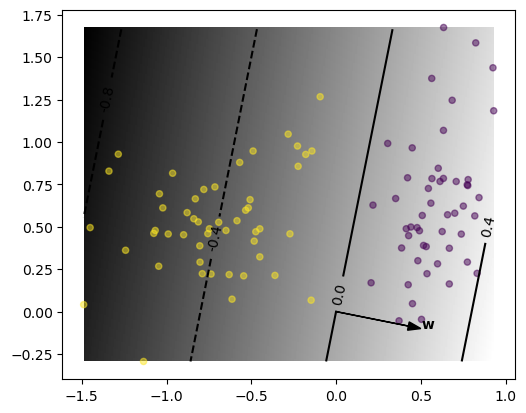

In [3]:
plt.style.use('default')
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5, s=20, cmap='viridis');

w = np.array([0.5, -0.1])
b = 0
delta = 0.01
xmin=np.min(X[:,0]);xmax=np.max(X[:,0]);ymin=np.min(X[:,1]);ymax=np.max(X[:,1])
xs = np.arange(xmin, xmax, delta)
ys = np.arange(ymin, ymax, delta)
x_grid, y_grid = np.meshgrid(xs, ys)

Z = w[0] * x_grid + w[1] * y_grid + b
    
im = plt.imshow(Z, origin='lower',
                cmap=plt.cm.gray, extent=(xmin,xmax,ymin,ymax) )

C = plt.contour(x_grid, y_grid, Z, 3, origin='lower',
                colors = 'black')

plt.clabel(C, fmt='%1.1f')

plt.arrow(0,0,w[0],w[1], width=0.001,head_width=0.05, length_includes_head=True, alpha=1,linestyle='-',color='k');
plt.text(w[0], w[1], r"$\mathbf{w}$");


While not all datasets are linearly separable, we will start by solving this simpler problem.
Also, we will focus on hyperplanes that go through the origin, i.e. $b=0$.

### The perceptron algorithm

The perceptron algorithm, proposed in 1958 by Frank Rosenblatt, is one of the first machine learning algorithms.  It is the precursor of neural networks.

**Idea:** iterate over the training examples, and update the weight vector $\mathbf{w}$ in a way that would make $\mathbf{x}_i$ is more likely to be correctly classified.

Let's assume $\mathbf{x}_i$ is a positive example that is incorrectly classified, i.e. $\mathbf{w}^\top \mathbf{x}_i < 0$.

Let's consider the update equation

$$
\mathbf{w}' = \mathbf{w} + \eta \mathbf{x}_i,
$$

where $1 > \eta > 0$ is a (small) positive number called the *learning rate*.

We'll verify that after the update we have that

$$
\mathbf{w}'^\top \mathbf{x}_i > \mathbf{w}^\top \mathbf{x}_i.
$$

This has the desired effect making $\mathbf{x}_i$ be more likely to be correctly classified.  This happens because the dot product of $\mathbf{x}_i$ with the weight vector is less likely to be negative after the update.

And indeed:

$$
\mathbf{w}'^\top \mathbf{x}_i = (\mathbf{w} + \eta \mathbf{x}_i)^\top  \mathbf{x}_i = \mathbf{w}^\top \mathbf{x}_i + \eta \mathbf{x}_i^\top  \mathbf{x}_i > \mathbf{w}^\top \mathbf{x}_i
$$

The latter inequality holds since for any non-zero vector, $\mathbf{x}^\top \mathbf{x} > 0$.

### Exercise

In deriving this inequality we relied on the following properties of the dot product:

* For any non-zero vector $\mathbf{x}$, we have that $\mathbf{x}^\top \mathbf{x} > 0$.
* For any vectors $\mathbf{u}, \mathbf{v}, \mathbf{w}$, we have that $(\mathbf{u} + \mathbf{v})^\top \mathbf{w} = \mathbf{u}^\top \mathbf{w} + \mathbf{v}^\top \mathbf{w}$

Using the definition of the dot product, verify that these properties hold.

If $\mathbf{x}_i$ is a negative example, the update needs to be in the opposite direction, since we want to make the dot product $\mathbf{w}^\top\mathbf{x}$ more negative.

Overall, we can summarize these two cases using the following equation:

$$
\mathbf{w}' = \mathbf{w} + y_i \eta \mathbf{x}_i
$$

This leads us to the following algorithm:

`The perceptron algorithm`

**input:**  a labeled dataset

**output:** a weight vector $\mathbf{w}$.

```
initialize w=0
converged = False
while not converged :
    converged = True
    for i in 1,...,N :
        if x_i is misclassified update w and set
            converged=False
return w
```

Each iteration over the entire dataset is called an **epoch**.

Next, let's create a Python class that implements this algorithm.

First, let's write a function that generates linearly separable data in two dimensions:

In [4]:
def generate_separable_data(N) :
    w = np.random.uniform(-1, 1, 2)
    X = np.random.uniform(-1, 1, [N, 2])
    y = np.sign(np.dot(X, w))
    return X,y,w

In [ ]:
generate_separable_data(10)

The following is a function to display the data and the weight vector:

In [5]:
def plot_data(X, y, w) :
    fig = plt.figure(figsize=(4,4))
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    a = -w[0]/w[1]
    pts = np.linspace(-1,1)
    plt.plot(pts, a*pts, 'k-')
    cols = {1: 'r', -1: 'b'}
    for i in range(len(X)): 
        plt.plot(X[i][0], X[i][1], cols[y[i]]+'o', alpha=0.6) 

In [ ]:
X,y,w = generate_separable_data(50)
plot_data(X, y, w)

And here's the Python class with the implementation of the perceptron:

In [6]:
class Perceptron :
 
    """An implementation of the perceptron algorithm.
    Note that this implementation does not include a bias term"""
 
    def __init__(self, iterations=100, learning_rate=0.2, 
                 plot_data=False) :
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.plot_data = plot_data
        
    def fit(self, X, y) :
        """
        Train a classifier using the perceptron training algorithm.
        After training the attribute 'w' will contain the perceptron weight vector.
 
        Parameters
        ----------
 
        X : ndarray, shape (num_examples, n_features)
        Training data.
 
        y : ndarray, shape (n_examples,)
        Array of labels.
 
        """
        self.w = np.zeros(len(X[0]))
        converged = False
        iterations = 0
        while (not converged and iterations <= self.iterations) :
            converged = True
            for i in range(len(X)) :
                if y[i] * self.decision_function(X[i]) <= 0 :
                    self.w = self.w + y[i] * self.learning_rate * X[i]
                    converged = False
                    if self.plot_data:
                        plot_data(X, y, self.w)
            iterations += 1
        self.converged = converged
        if converged :
            print ('converged in %d iterations ' % iterations)
 
    def decision_function(self, x) :
        return np.dot(x, self.w)
 
    def predict(self, X) :
        """
        make predictions using a trained linear classifier
 
        Parameters
        ----------
 
        X : ndarray, shape (num_examples, n_features)
        Training data.
        """
 
        scores = np.dot(X, self.w)
        return np.sign(scores)
 


In [ ]:
X,y,w = generate_separable_data(40)
p = Perceptron(plot_data=True)
p.fit(X,y)

In [ ]:
p = Perceptron()
p.iterations

Let's compare the two weight vectors:

In [ ]:
p.w, w

Let's normalize the two vectors into unit vectors:

In [ ]:
print(p.w/np.sqrt(np.dot(p.w, p.w)))
print(w/np.sqrt(np.dot(w, w)))

Now we can see that they are pointing more or less in the same direction!

Our algorithm as stated above has several limitations:

* The hyperplane goes through the origin.
* The algorithm doesn't converge if the data is not linearly separable.

To address the second limitation, all you need to do is add a limit on the number of iterations, which is what we did in the code.
To address the first, we'll show a trick for introducing a bias without actually having to modify the algorithm.  To do so, we'll modify the data instead.

Let's add another dimension to our weight vector, and a constant feature to our data:

$\tilde{\mathbf{w}}=[w_1,\ldots,w_d,w_{d+1}]^\top$

$\tilde{\mathbf{x}}= [x_1,\ldots,x_d,1]^\top$

With these definitions, you can easily verify that 

$$
\tilde{\mathbf{w}}^\top \tilde{\mathbf{x}} = \mathbf{w}^\top \mathbf{x}
+ w_{d+1}
$$

i.e. $w_{d+1}$ is equivalent to the bias term.

### The perceptron algorithm applied to the Wisconsin breast cancer dataset

The Wisconsin breast cancer is one of the scikit-learn built in datasets.  It is available from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)), which is one of the earliest web resources for machine learning datasets.

The dataset quantifies cancerous breast tissue, and the task is to try and distinguish between benign and malignant cancer.  The features are computed from images of tissue biopsies.


In [27]:
from sklearn.datasets import load_breast_cancer
X,y = data = load_breast_cancer(return_X_y = True)
X.shape, y.shape

((569, 30), (569,))

Why do we need to do the following?

In [28]:
y = y * 2 - 1

In view of our discussion above, to implement a bias term all we need to do is add a column of ones to our feature matrix:

In [29]:
X = np.hstack([X, np.ones((len(X), 1))])
X.shape

In [36]:
from sklearn.model_selection import train_test_split
p = Perceptron(iterations = 500, learning_rate = 0.1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=5)

In [37]:
p = Perceptron(iterations = 500, learning_rate = 0.1)
p.fit(X_train, y_train)
y_pred = p.predict(X_test)
print('accuracy: ', np.mean(y_test == y_pred))

accuracy:  0.8421052631578947


For comparison let's evaluate the perceptron on the training set

In [38]:
y_pred = p.predict(X_train)
print('accuracy: ', np.mean(y_train == y_pred))

accuracy:  0.8291457286432161


Surprised?  Why is that?

### Digression:  machine learning repositories

The availability of web-accessible datasets that can be readily analyzed has been a driving force in the development of machine learning.  The [UCI machine learning repository](https://archive.ics.uci.edu/ml/index.php) has been one of the early sources, and the datasets available from it have been widely used for benchmarking in the  machine learning literature.  The rapid growth in the number of machine learning practitioners has led to development of resources such as [Kaggle](https://www.kaggle.com), which allows for people to test their skills in machine learning competitions that are posted on a regular basis.  [Open ML](https://www.openml.org), is also a good resource (see also their [list of useful ML repositories](https://docs.openml.org/Data-Repositories/).  Given their interest in ML, it's not surprising that Google has a specific tool for [dataset search](https://datasetsearch.research.google.com/).


### Exercises

* Explore the accuracy of the perceptron on the breast cancer dataset while varying the number of epochs that the perceptron is trained.  Measure accuracy on both the training and test sets.  What can you conclude?

* Can you tell if the dataset is linearly separable?

* Do you observe differences in performance by changing the learning rate?

* Run the perceptron on 10 different train-test splits.  Compute the accuracy on each split.  What is the average and standard deviation that you observe?  (You can use `np.mean` and `np.std` for computing these statistics).

### Pros and cons of the perceptron

Here are some points in favor and against the perceptron:

####  Pros 

* Simple and easy to implement
* Relatively fast to train

#### Cons

Even with the fixes we made to the perceptron, there are still a couple of issues with the algorithm:

* Our algorithms contains several *hyperparameters*:  number of epochs, and learning rate.  It is not clear how to set those parameters.

* The solution bounces around and the algorithm chooses an arbitrary hyperplane that separates the two classes.  It may not be the best one from the learning perspective.

* Limited to linear decision boundaries.

* Limited to binary classification problems.

During the rest of this course we will learn algorithms that  address these issues in different ways.

### Linear classifiers

The perceptron is a simple algorithm for constructing linear decision boundaries.  Would we actually use it in practice?  Or more generally would we use linear algorithms in practice?  The answer is yes!  For the following reasons:

* A linear algorithm is a good baseline:  always start simple
* Linear models are stable
* Linear models are *less likely to overfit* the training data because they have less parameters.  
* Can sometimes *underfit*.  
* Often all you need when the data is high dimensional.
* Lots of scalable algorithms.

In summary, there is always a place for simple algorithms that can be trained quickly and give you a good idea of how hard a given classification problem is.

### The perceptron and the origins of artificial neural networks

Frank Rosenblatt who invented the algorithm did not initially intend for its use as a machine learning algorithm (a term that did not exist at the time):

> The perceptron program is not primarily concerned with the invention of devices for "artificial intelligence", but rather with investigating the physical structures and neurodynamic principles which underlie "natural intelligence." A perceptron is first and foremost a brain model, not an invention for pattern recognition.

The limitations of the simple version of the perceptron shown here were described in great detail in the book [Perceptrons: an introduction to computational geometry](https://en.wikipedia.org/wiki/Perceptrons_(book)) by Minsky and Pappert.  Publication of this book has stalled the development of the field for close to a decade.

### References

* Rosenblatt, Frank. "The perceptron: a probabilistic model for information storage and organization in the brain." Psychological review 65.6 (1958): 386.